<a href="https://colab.research.google.com/github/Victorlouisdg/simulators/blob/main/fluid_2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
matplotlib.rc('animation', html='jshtml')

# Defining the grid

<img src="https://i.imgur.com/3FlzvX5.png" width=500 />

In [2]:
n = amount_of_cells = 32
velocity_grid = np.zeros((n, n, 2))
cell_size = 1.0 / n
dt = 0.01

In [3]:
def get_cell_center(i, j):
    return (i * cell_size, j * cell_size)

get_cell_center(1, 2)

(0.03125, 0.0625)

In [4]:
def get_float_cell_index(x, y):
    return (x / cell_size, y / cell_size)

get_float_cell_index(1/2 * cell_size, cell_size)

(0.5, 1.0)

# Diffusion
Diffusion in balance when a cell is the average of it's neighbors.

(Laplacian = sum of second order derivatives)

One way to implement this:

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSu3WvQYcbjMTdkvVfeZiTUaDB0NLW0LqtVaQ&usqp=CAU" />



In [5]:
def laplacian(grid, i, j):
    value_center = -4 * grid[i, j]
    value_left = grid[i, max(j - 1, 0)]
    value_right = grid[i, min(j + 1, grid.shape[1] - 1)]
    value_above = grid[max(i - 1, 0), j]
    value_below = grid[min(i + 1, grid.shape[0] - 1), j]

    return value_center + value_left + value_right + value_above + value_below

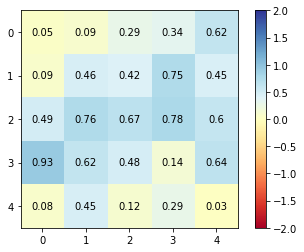

In [6]:
d = 5
random_grid = np.random.random((d, d))

plt.imshow(random_grid, cmap="RdYlBu", vmin=-2, vmax=2)
plt.colorbar();

ax = plt.gca()

for i in range(d):
    for j in range(d):
        text = plt.text(j, i, np.round(random_grid[i, j], 2),ha="center", va="center")

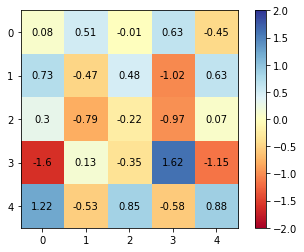

In [7]:
laplacian_grid = np.zeros((d, d))

for i in range(d):
    for j in range(d):
        laplacian_grid[i, j] = laplacian(random_grid, i, j)

plt.imshow(laplacian_grid, cmap="RdYlBu", vmin=-2, vmax=2)
plt.colorbar();

for i in range(d):
    for j in range(d):
        text = plt.text(j, i, np.round(laplacian_grid[i, j], 2), ha="center", va="center")

In [8]:
density_grid = np.random.random((n, n))

def diffuse(grid, viscocity, dt):
    grid_new = np.zeros_like(grid)

    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            grid_new[i, j] = grid[i, j] + laplacian(grid, i, j) * viscocity * dt

    return grid_new

grid = density_grid
diffusion_history = [grid]

for i in range(20):
    grid_new = diffuse(grid, viscocity=1.0, dt=0.1)
    diffusion_history.append(grid_new)
    grid = grid_new

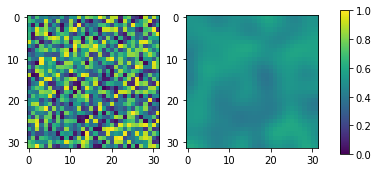

In [9]:
def plot_image_side_by_side(image_left, image_right):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    im = ax1.imshow(image_left , vmin=0, vmax=1)
    ax2.imshow(image_right, vmin=0, vmax=1)

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.25, 0.02, 0.5])
    fig.colorbar(im, cax=cbar_ax);

plot_image_side_by_side(density_grid, grid)

In [ ]:
def animate_image_list(image_list):
    fig = plt.figure(figsize=(4, 4), dpi=100)
    ax = fig.add_subplot(111)
    plt.close()  # prevents duplicate output 

    def animate(i):
        ax.imshow(image_list[i] , vmin=0, vmax=1)
        
    return animation.FuncAnimation(fig, animate, frames=len(image_list))

animate_image_list(diffusion_history)

In [11]:
density_grid = np.random.random((n, n))

def diffuse_jacobi(grid, viscocity, dt, iterations=5):
    original_grid = grid.copy()
    grid_new = np.zeros_like(grid)

    for _ in range(iterations):
        for i in range(grid.shape[0]):
            for j in range(grid.shape[1]):
                value_left = grid[i, max(j - 1, 0)]
                value_right = grid[i, min(j + 1, grid.shape[1] - 1)]
                value_above = grid[max(i - 1, 0), j]
                value_below = grid[min(i + 1, grid.shape[0] - 1), j]
                value_neighbors = value_left + value_right + value_above + value_below
                a = viscocity * dt

                grid_new[i, j] = (original_grid[i, j] + value_neighbors * a) / (1 + 4 * a)

        grid = grid_new

    return grid

grid = density_grid
diffusion_history = [grid]

for i in range(20):
    grid_new = diffuse_jacobi(grid, viscocity=1.0, dt=0.1)
    diffusion_history.append(grid_new)
    grid = grid_new

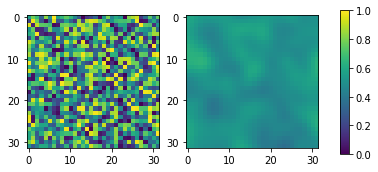

In [12]:
plot_image_side_by_side(density_grid, grid)

In [ ]:
animate_image_list(diffusion_history)

# Bilinear interpolation

Bilinear interpolation is a way to interpolate the value at in point in 2D from 4 other points.

I find the simplest way to understand it with a color-coded image:


<img src="https://i.imgur.com/tfiWC5f.png" width=500 />

Here the contribution of the yellow point's value to the pink point, is proportional to the yellow area.
This makes intuiive sense because the closer the pink point is to the yellow point, the larger yellow area becomes.

In [14]:
def interpolate_bilinear(grid, i_float, j_float):
    i = int(np.floor(i_float))
    j = int(np.floor(j_float))

    a = i_fractional_part = i_float - i
    b = j_fractional_part = j_float - j

    red = a * b
    green = a * (1 - b)
    blue = (1 - a) * b
    yellow = (1 - a) * (1 - b)

    # When a value is OOB, use the value inside instead
    i = max(i, 0)
    i_1 = min(i + 1, grid.shape[0] - 1)
    j = max(j, 0)
    j_1 = min(j+ 1, grid.shape[1] - 1)

    return yellow * grid[i, j] + \
           green * grid[i_1, j] + \
           blue * grid[i, j_1] + \
           red * grid[i_1, j_1]

In [15]:
mini_grid = np.array([[1, 0.5], [0, 1]])
print(mini_grid)

[[1.  0.5]
 [0.  1. ]]


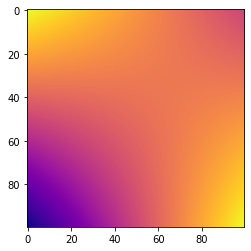

In [16]:
steps = 100
step_size = 1.0 / (steps - 1)
grid_interpolated = np.zeros((steps, steps))

for k in range(steps):
    for l in range(steps):
        grid_interpolated[k, l] = interpolate_bilinear(mini_grid, k * step_size, l * step_size)

fig = plt.figure(figsize=(4, 4))
plt.imshow(grid_interpolated,  cmap=plt.get_cmap("plasma"));

# Advection

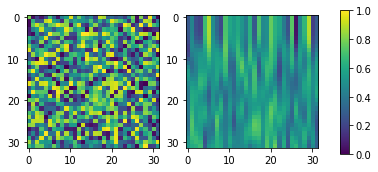

In [17]:
density_grid = np.random.random((n, n))
velocity_grid = np.zeros((n, n, 2))
velocity_grid[..., 0] = 1.0  # downwards velocity

def advect(quantity, velocity_grid):
    quantity_new = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            p = get_cell_center(i, j)
            v = velocity_grid[i, j]
            p_back = p - v * dt

            x, y = p_back
            i_float, j_float = get_float_cell_index(x, y)
            quantity_new[i, j] = interpolate_bilinear(quantity, i_float, j_float)
    return quantity_new


grid = density_grid.copy()


grid = density_grid
advection_history = [grid]

for i in range(20):
    grid_new = advect(grid, velocity_grid)
    advection_history.append(grid_new)
    grid = grid_new

plot_image_side_by_side(density_grid, grid)

In [ ]:
animate_image_list(advection_history)

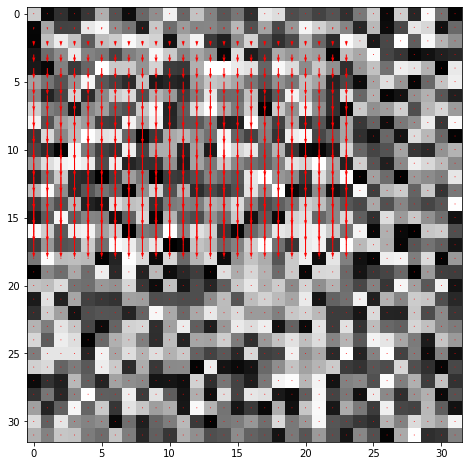

In [19]:
plt.figure(figsize=(8, 8))
plt.imshow(density_grid, cmap='gist_gray')

velocity_grid = np.zeros((n, n, 2))
velocity_grid[:16, :24, 0] = 1.0  # downwards velocity


for i in range(n):
    velocity_grid[i, ...] *= i

X = []
Y = [] 
U = []
V = []

for i in range(n):
    for j in range(n):
        X.append(j)
        Y.append(i)
        U.append(velocity_grid[i, j, 1])
        V.append(-velocity_grid[i, j, 0])

q = plt.quiver(X, Y, U, V, color='red')

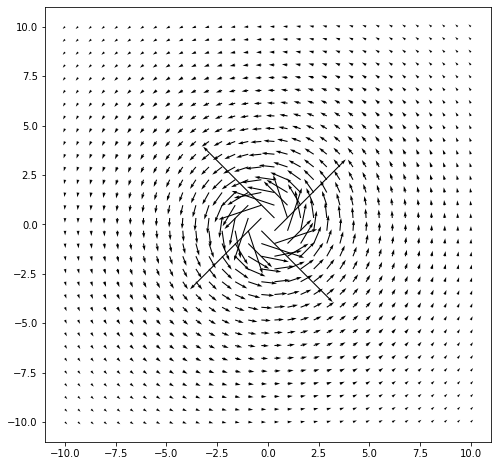

In [20]:
# Defining variables
plt.figure(figsize=(8,8))

x = np.linspace(-10,10, n)
y = np.linspace(-10,10, n)
X,Y = np.meshgrid(x,y)

# Vector field
vx = -Y/(X**2 + Y**2)
vy = X/(X**2 + Y**2)

plt.quiver(X, Y,vx,vy);